# Breaking a CAPTCHA system

Ref: https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710

In [4]:
%%javascript
IPython.notebook.clear_all_output();

<IPython.core.display.Javascript object>

Install some packages below (if not installed already):

In [ ]:
!pip install opencv-python
!pip install imutils
!conda install pydot -y
!conda install graphviz -y

In [ ]:
pip install tensorflow==2.11.0 --user

In [ ]:
pip install graphviz

In [ ]:
pip install pydot

In [ ]:
pip install pydotplus

In this exercise you will break `Really Simple CAPTCHA` plugin of WordPress: https://wordpress.org/plugins/really-simple-captcha/

Try a demo here: https://contactform7.com/captcha/

The plugin generates 4-letter CAPTCHAs using a random mix of four different fonts. Letters are from 'ABCDEFGHJKLMNPQRSTUVWXYZ23456789' and "O", "I" and "1" are not used to avoid user confusion. That leaves us with a total of 32 possible letters and numbers that we need to recognize.

Since we have the source code to the WordPress plug-in, we can modify it to save out CAPTCHA images along with the expected answer for each image. We generated 9955 images under folder `generated_captcha_images`. Run the following code to show 10 images to take a look.

In [5]:
CAPTCHA_IMAGE_FOLDER = "generated_captcha_images"

## Step 1: Extract single letters from CAPTCHA images

### Run the following code to show 10 images to take a look.

In [6]:
import os.path
import glob # glob.glob returns the list of files with their full path, and it supports wildcards

from IPython.display import Image

captcha_image_files = glob.glob(os.path.join(CAPTCHA_IMAGE_FOLDER, "*"))

for (i, captcha_image_file) in enumerate(captcha_image_files):
    if i==10: break
    print(captcha_image_file)
    display(Image(filename=captcha_image_file))

generated_captcha_images\222X.png


generated_captcha_images\226U.png


generated_captcha_images\2274.png


generated_captcha_images\22A6.png


generated_captcha_images\22BJ.png


generated_captcha_images\22HS.png


generated_captcha_images\22KD.png


generated_captcha_images\22L9.png


generated_captcha_images\22NR.png


generated_captcha_images\22PL.png


### Now we illustrate how to process an image `generated_captcha_images/222X.png`

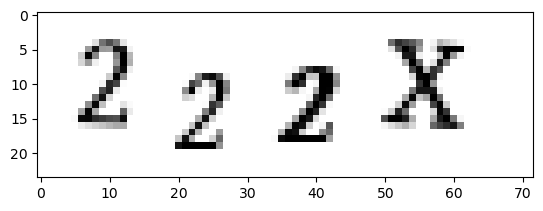

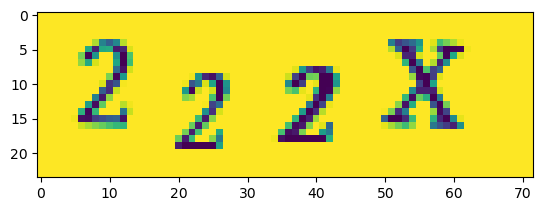

In [8]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
from matplotlib import pyplot as plt
import cv2 # OpenCV, a popular framework for computer vision and image processing

captcha_image_file = 'generated_captcha_images/222X.png' # normal
# captcha_image_file = 'generated_captcha_images/2W4M.png' # try this: 3 objects, 2 letters are merged
# captcha_image_file = 'generated_captcha_images/3PH3.png' # try this: 5 objects detected
# captcha_image_file = 'generated_captcha_images/JYU4.png' # try this: 6 objects detected

captcha_correct_text = os.path.splitext(captcha_image_file)[0]

# Load the image and convert it to grayscale
image = cv2.imread(captcha_image_file)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Show the image with matplotlib
plt.imshow(image)
plt.show()

plt.imshow(gray)
plt.show()

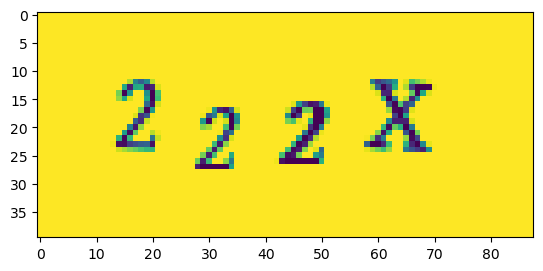

In [9]:
# Add some extra padding around the image
gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

plt.imshow(gray)
plt.show()

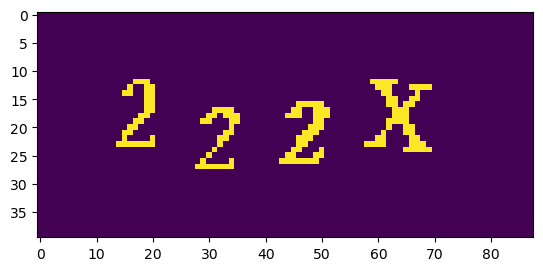

In [10]:
# threshold the image (convert it to pure black and white)
# we use Otsu’s binarization
# check: https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

plt.imshow(thresh)
plt.show()

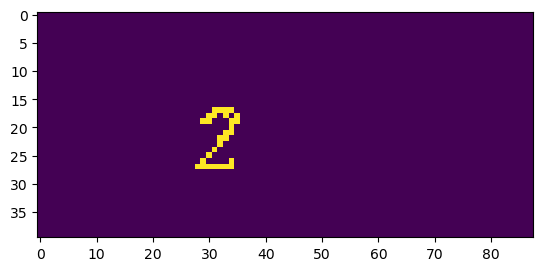

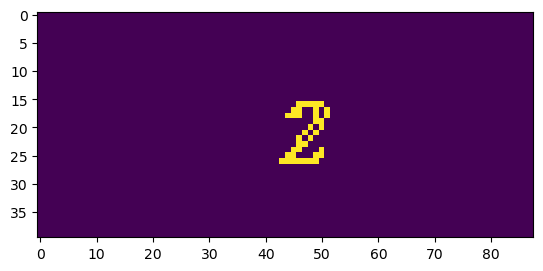

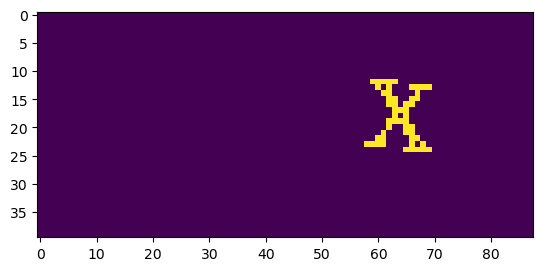

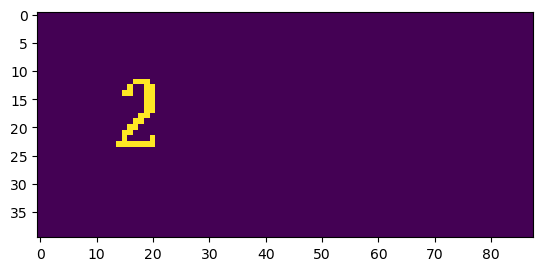

In [12]:
import numpy as np

# find the contours (continuous blobs of pixels) the image
# check:
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_begin/py_contours_begin.html#contours-getting-started
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
# !!! if the cell reports error, replace [0] above with [1]

zero_img = np.zeros_like(thresh)

for i in range(len(contours)):
    temp = cv2.drawContours(zero_img.copy(), contours, i, (255,0,0), 1)
    plt.imshow(temp)
    plt.show()

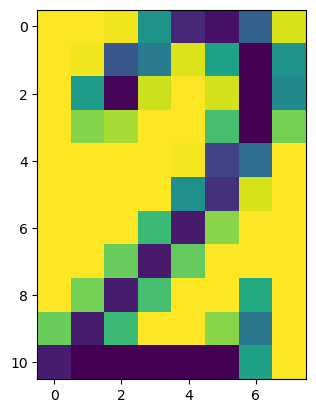

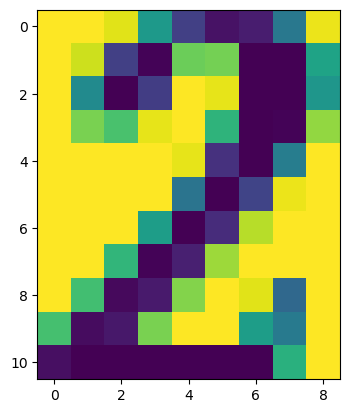

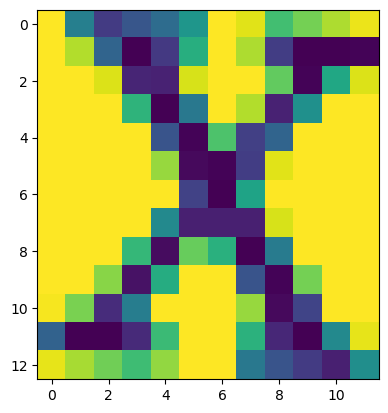

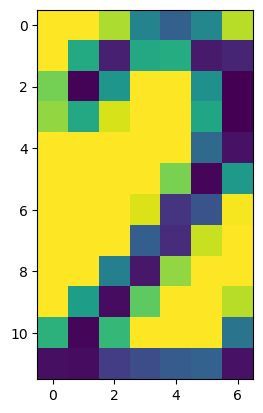

In [13]:
for contour in contours:
    # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)
    letter_image = gray[y:y+h, x:x+w]
    plt.imshow(letter_image)
    plt.show()

### Putting things together: get letters from images

Using what we have learnt above, write your code to save get the letters of all images. The letter-images are stored as 32 folders under folder `extracted_letter_images`.

For example, `extracted_letter_images/A` is a folder that saves all images of letter `A`. After you complete, each letter-folder should contain over 1000 letter-images.

Hint: (1) consider how to name different files in a letter-folder differently? (2) ingore those images with number of contours other than 4.

In [14]:
import os
import imutils

LETTER_IMAGES_FOLDER = "extracted_letter_images" # the output for training
SKIPPED_FOLDER = "skipped_images" # those images are skipped
counts = {} # counts['A'] = number of 'A'-images, so that next 'A'-image can be named as counts['A'] + 1

# function to extract letter regions from contours
# looping through each of the four contours and extracting the letter areas
def extractLetterFromContours(letterAreas,contours):
    for contour in contours:
        # Get Area containing contour
        (x1, x2, width, height) = cv2.boundingRect(contour)

        if width / height > 1.25: 
            half_W = int(width / 2) #If the width is larger, divide it into half for 2 letter areas
            letterAreas.append((x1, x2, half_W, height))
            letterAreas.append((x1 + half_W, x2, half_W, height))
        else:
            letterAreas.append((x1, x2, width, height))
            
#function to get text from filename of captcha Image
def getCaptchaText(captchaImageFile):
    imageFileName = os.path.basename(captchaImageFile)
    return os.path.splitext(imageFileName)[0]

#function to save individual letter images into corresponding letter folders
def saveImage(extractedLetterImage,extractedLetterText):
    letterFolderPath = os.path.join(LETTER_IMAGES_FOLDER, extractedLetterText)

    # creating folder if folder path doesnot exist
    if not os.path.exists(letterFolderPath):
        os.makedirs(letterFolderPath)

    count = counts.get(extractedLetterText, 1)
    imagePath = os.path.join(letterFolderPath, "{}.png".format(str(count).zfill(6)))
    cv2.imwrite(imagePath, extractedLetterImage)

        # incrementing the count for letter
    counts[extractedLetterText] = count + 1
    
            
# loop over the image paths
for (i, captchaImageFile) in enumerate(captcha_image_files):
    print("[INFO] processing image {}/{}".format(i + 1, len(captcha_image_files)))
    
    captchaText = getCaptchaText(captchaImageFile)  # getting text from captcha image file name
    
    # getting image and converting into gray scale
    captchaImage = cv2.imread(captchaImageFile)   
    grayImage = cv2.cvtColor(captchaImage, cv2.COLOR_BGR2GRAY)
    
    grayImage = cv2.copyMakeBorder(grayImage, 8, 8, 8, 8, cv2.BORDER_REPLICATE) # adding some padding to the gray image

    threshImage = cv2.threshold(grayImage, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # finding the captcha image contours
    contours = cv2.findContours(threshImage.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours = contours[1] if imutils.is_cv3() else contours[0]

    letterAreas = []

    #extracting individual letters from contours
    extractLetterFromContours(letterAreas,contours)
    

    # Skipping saving images if length is other than 4
    if len(letterAreas) != 4:
        continue

    # Based on the x coordinate,sorting the letter images 
    letterAreas = sorted(letterAreas, key=lambda x1: x1[0])

    for letterBoundArea, extractedLetterText in zip(letterAreas, captchaText):
        # getting the coordinates of each letter
        x1, x2, width, height= letterBoundArea

        # Extracting the letter from the captcha image with a margin of  2-px
        extractedLetterImage = grayImage[x2 - 2:x2 + height + 2, x1 - 2:x1 + width + 2]

        saveImage(extractedLetterImage,extractedLetterText)
  
   
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

[INFO] processing image 1/9956
[INFO] processing image 2/9956
[INFO] processing image 3/9956
[INFO] processing image 4/9956
[INFO] processing image 5/9956
[INFO] processing image 6/9956
[INFO] processing image 7/9956
[INFO] processing image 8/9956
[INFO] processing image 9/9956
[INFO] processing image 10/9956
[INFO] processing image 11/9956
[INFO] processing image 12/9956
[INFO] processing image 13/9956
[INFO] processing image 14/9956
[INFO] processing image 15/9956
[INFO] processing image 16/9956
[INFO] processing image 17/9956
[INFO] processing image 18/9956
[INFO] processing image 19/9956
[INFO] processing image 20/9956
[INFO] processing image 21/9956
[INFO] processing image 22/9956
[INFO] processing image 23/9956
[INFO] processing image 24/9956
[INFO] processing image 25/9956
[INFO] processing image 26/9956
[INFO] processing image 27/9956
[INFO] processing image 28/9956
[INFO] processing image 29/9956
[INFO] processing image 30/9956
[INFO] processing image 31/9956
[INFO] processing

[INFO] processing image 261/9956
[INFO] processing image 262/9956
[INFO] processing image 263/9956
[INFO] processing image 264/9956
[INFO] processing image 265/9956
[INFO] processing image 266/9956
[INFO] processing image 267/9956
[INFO] processing image 268/9956
[INFO] processing image 269/9956
[INFO] processing image 270/9956
[INFO] processing image 271/9956
[INFO] processing image 272/9956
[INFO] processing image 273/9956
[INFO] processing image 274/9956
[INFO] processing image 275/9956
[INFO] processing image 276/9956
[INFO] processing image 277/9956
[INFO] processing image 278/9956
[INFO] processing image 279/9956
[INFO] processing image 280/9956
[INFO] processing image 281/9956
[INFO] processing image 282/9956
[INFO] processing image 283/9956
[INFO] processing image 284/9956
[INFO] processing image 285/9956
[INFO] processing image 286/9956
[INFO] processing image 287/9956
[INFO] processing image 288/9956
[INFO] processing image 289/9956
[INFO] processing image 290/9956
[INFO] pro

[INFO] processing image 516/9956
[INFO] processing image 517/9956
[INFO] processing image 518/9956
[INFO] processing image 519/9956
[INFO] processing image 520/9956
[INFO] processing image 521/9956
[INFO] processing image 522/9956
[INFO] processing image 523/9956
[INFO] processing image 524/9956
[INFO] processing image 525/9956
[INFO] processing image 526/9956
[INFO] processing image 527/9956
[INFO] processing image 528/9956
[INFO] processing image 529/9956
[INFO] processing image 530/9956
[INFO] processing image 531/9956
[INFO] processing image 532/9956
[INFO] processing image 533/9956
[INFO] processing image 534/9956
[INFO] processing image 535/9956
[INFO] processing image 536/9956
[INFO] processing image 537/9956
[INFO] processing image 538/9956
[INFO] processing image 539/9956
[INFO] processing image 540/9956
[INFO] processing image 541/9956
[INFO] processing image 542/9956
[INFO] processing image 543/9956
[INFO] processing image 544/9956
[INFO] processing image 545/9956
[INFO] pro

[INFO] processing image 763/9956
[INFO] processing image 764/9956
[INFO] processing image 765/9956
[INFO] processing image 766/9956
[INFO] processing image 767/9956
[INFO] processing image 768/9956
[INFO] processing image 769/9956
[INFO] processing image 770/9956
[INFO] processing image 771/9956
[INFO] processing image 772/9956
[INFO] processing image 773/9956
[INFO] processing image 774/9956
[INFO] processing image 775/9956
[INFO] processing image 776/9956
[INFO] processing image 777/9956
[INFO] processing image 778/9956
[INFO] processing image 779/9956
[INFO] processing image 780/9956
[INFO] processing image 781/9956
[INFO] processing image 782/9956
[INFO] processing image 783/9956
[INFO] processing image 784/9956
[INFO] processing image 785/9956
[INFO] processing image 786/9956
[INFO] processing image 787/9956
[INFO] processing image 788/9956
[INFO] processing image 789/9956
[INFO] processing image 790/9956
[INFO] processing image 791/9956
[INFO] processing image 792/9956
[INFO] pro

[INFO] processing image 1011/9956
[INFO] processing image 1012/9956
[INFO] processing image 1013/9956
[INFO] processing image 1014/9956
[INFO] processing image 1015/9956
[INFO] processing image 1016/9956
[INFO] processing image 1017/9956
[INFO] processing image 1018/9956
[INFO] processing image 1019/9956
[INFO] processing image 1020/9956
[INFO] processing image 1021/9956
[INFO] processing image 1022/9956
[INFO] processing image 1023/9956
[INFO] processing image 1024/9956
[INFO] processing image 1025/9956
[INFO] processing image 1026/9956
[INFO] processing image 1027/9956
[INFO] processing image 1028/9956
[INFO] processing image 1029/9956
[INFO] processing image 1030/9956
[INFO] processing image 1031/9956
[INFO] processing image 1032/9956
[INFO] processing image 1033/9956
[INFO] processing image 1034/9956
[INFO] processing image 1035/9956
[INFO] processing image 1036/9956
[INFO] processing image 1037/9956
[INFO] processing image 1038/9956
[INFO] processing image 1039/9956
[INFO] process

[INFO] processing image 1265/9956
[INFO] processing image 1266/9956
[INFO] processing image 1267/9956
[INFO] processing image 1268/9956
[INFO] processing image 1269/9956
[INFO] processing image 1270/9956
[INFO] processing image 1271/9956
[INFO] processing image 1272/9956
[INFO] processing image 1273/9956
[INFO] processing image 1274/9956
[INFO] processing image 1275/9956
[INFO] processing image 1276/9956
[INFO] processing image 1277/9956
[INFO] processing image 1278/9956
[INFO] processing image 1279/9956
[INFO] processing image 1280/9956
[INFO] processing image 1281/9956
[INFO] processing image 1282/9956
[INFO] processing image 1283/9956
[INFO] processing image 1284/9956
[INFO] processing image 1285/9956
[INFO] processing image 1286/9956
[INFO] processing image 1287/9956
[INFO] processing image 1288/9956
[INFO] processing image 1289/9956
[INFO] processing image 1290/9956
[INFO] processing image 1291/9956
[INFO] processing image 1292/9956
[INFO] processing image 1293/9956
[INFO] process

[INFO] processing image 1513/9956
[INFO] processing image 1514/9956
[INFO] processing image 1515/9956
[INFO] processing image 1516/9956
[INFO] processing image 1517/9956
[INFO] processing image 1518/9956
[INFO] processing image 1519/9956
[INFO] processing image 1520/9956
[INFO] processing image 1521/9956
[INFO] processing image 1522/9956
[INFO] processing image 1523/9956
[INFO] processing image 1524/9956
[INFO] processing image 1525/9956
[INFO] processing image 1526/9956
[INFO] processing image 1527/9956
[INFO] processing image 1528/9956
[INFO] processing image 1529/9956
[INFO] processing image 1530/9956
[INFO] processing image 1531/9956
[INFO] processing image 1532/9956
[INFO] processing image 1533/9956
[INFO] processing image 1534/9956
[INFO] processing image 1535/9956
[INFO] processing image 1536/9956
[INFO] processing image 1537/9956
[INFO] processing image 1538/9956
[INFO] processing image 1539/9956
[INFO] processing image 1540/9956
[INFO] processing image 1541/9956
[INFO] process

[INFO] processing image 1757/9956
[INFO] processing image 1758/9956
[INFO] processing image 1759/9956
[INFO] processing image 1760/9956
[INFO] processing image 1761/9956
[INFO] processing image 1762/9956
[INFO] processing image 1763/9956
[INFO] processing image 1764/9956
[INFO] processing image 1765/9956
[INFO] processing image 1766/9956
[INFO] processing image 1767/9956
[INFO] processing image 1768/9956
[INFO] processing image 1769/9956
[INFO] processing image 1770/9956
[INFO] processing image 1771/9956
[INFO] processing image 1772/9956
[INFO] processing image 1773/9956
[INFO] processing image 1774/9956
[INFO] processing image 1775/9956
[INFO] processing image 1776/9956
[INFO] processing image 1777/9956
[INFO] processing image 1778/9956
[INFO] processing image 1779/9956
[INFO] processing image 1780/9956
[INFO] processing image 1781/9956
[INFO] processing image 1782/9956
[INFO] processing image 1783/9956
[INFO] processing image 1784/9956
[INFO] processing image 1785/9956
[INFO] process

[INFO] processing image 1998/9956
[INFO] processing image 1999/9956
[INFO] processing image 2000/9956
[INFO] processing image 2001/9956
[INFO] processing image 2002/9956
[INFO] processing image 2003/9956
[INFO] processing image 2004/9956
[INFO] processing image 2005/9956
[INFO] processing image 2006/9956
[INFO] processing image 2007/9956
[INFO] processing image 2008/9956
[INFO] processing image 2009/9956
[INFO] processing image 2010/9956
[INFO] processing image 2011/9956
[INFO] processing image 2012/9956
[INFO] processing image 2013/9956
[INFO] processing image 2014/9956
[INFO] processing image 2015/9956
[INFO] processing image 2016/9956
[INFO] processing image 2017/9956
[INFO] processing image 2018/9956
[INFO] processing image 2019/9956
[INFO] processing image 2020/9956
[INFO] processing image 2021/9956
[INFO] processing image 2022/9956
[INFO] processing image 2023/9956
[INFO] processing image 2024/9956
[INFO] processing image 2025/9956
[INFO] processing image 2026/9956
[INFO] process

[INFO] processing image 2242/9956
[INFO] processing image 2243/9956
[INFO] processing image 2244/9956
[INFO] processing image 2245/9956
[INFO] processing image 2246/9956
[INFO] processing image 2247/9956
[INFO] processing image 2248/9956
[INFO] processing image 2249/9956
[INFO] processing image 2250/9956
[INFO] processing image 2251/9956
[INFO] processing image 2252/9956
[INFO] processing image 2253/9956
[INFO] processing image 2254/9956
[INFO] processing image 2255/9956
[INFO] processing image 2256/9956
[INFO] processing image 2257/9956
[INFO] processing image 2258/9956
[INFO] processing image 2259/9956
[INFO] processing image 2260/9956
[INFO] processing image 2261/9956
[INFO] processing image 2262/9956
[INFO] processing image 2263/9956
[INFO] processing image 2264/9956
[INFO] processing image 2265/9956
[INFO] processing image 2266/9956
[INFO] processing image 2267/9956
[INFO] processing image 2268/9956
[INFO] processing image 2269/9956
[INFO] processing image 2270/9956
[INFO] process

[INFO] processing image 2483/9956
[INFO] processing image 2484/9956
[INFO] processing image 2485/9956
[INFO] processing image 2486/9956
[INFO] processing image 2487/9956
[INFO] processing image 2488/9956
[INFO] processing image 2489/9956
[INFO] processing image 2490/9956
[INFO] processing image 2491/9956
[INFO] processing image 2492/9956
[INFO] processing image 2493/9956
[INFO] processing image 2494/9956
[INFO] processing image 2495/9956
[INFO] processing image 2496/9956
[INFO] processing image 2497/9956
[INFO] processing image 2498/9956
[INFO] processing image 2499/9956
[INFO] processing image 2500/9956
[INFO] processing image 2501/9956
[INFO] processing image 2502/9956
[INFO] processing image 2503/9956
[INFO] processing image 2504/9956
[INFO] processing image 2505/9956
[INFO] processing image 2506/9956
[INFO] processing image 2507/9956
[INFO] processing image 2508/9956
[INFO] processing image 2509/9956
[INFO] processing image 2510/9956
[INFO] processing image 2511/9956
[INFO] process

[INFO] processing image 2729/9956
[INFO] processing image 2730/9956
[INFO] processing image 2731/9956
[INFO] processing image 2732/9956
[INFO] processing image 2733/9956
[INFO] processing image 2734/9956
[INFO] processing image 2735/9956
[INFO] processing image 2736/9956
[INFO] processing image 2737/9956
[INFO] processing image 2738/9956
[INFO] processing image 2739/9956
[INFO] processing image 2740/9956
[INFO] processing image 2741/9956
[INFO] processing image 2742/9956
[INFO] processing image 2743/9956
[INFO] processing image 2744/9956
[INFO] processing image 2745/9956
[INFO] processing image 2746/9956
[INFO] processing image 2747/9956
[INFO] processing image 2748/9956
[INFO] processing image 2749/9956
[INFO] processing image 2750/9956
[INFO] processing image 2751/9956
[INFO] processing image 2752/9956
[INFO] processing image 2753/9956
[INFO] processing image 2754/9956
[INFO] processing image 2755/9956
[INFO] processing image 2756/9956
[INFO] processing image 2757/9956
[INFO] process

[INFO] processing image 2973/9956
[INFO] processing image 2974/9956
[INFO] processing image 2975/9956
[INFO] processing image 2976/9956
[INFO] processing image 2977/9956
[INFO] processing image 2978/9956
[INFO] processing image 2979/9956
[INFO] processing image 2980/9956
[INFO] processing image 2981/9956
[INFO] processing image 2982/9956
[INFO] processing image 2983/9956
[INFO] processing image 2984/9956
[INFO] processing image 2985/9956
[INFO] processing image 2986/9956
[INFO] processing image 2987/9956
[INFO] processing image 2988/9956
[INFO] processing image 2989/9956
[INFO] processing image 2990/9956
[INFO] processing image 2991/9956
[INFO] processing image 2992/9956
[INFO] processing image 2993/9956
[INFO] processing image 2994/9956
[INFO] processing image 2995/9956
[INFO] processing image 2996/9956
[INFO] processing image 2997/9956
[INFO] processing image 2998/9956
[INFO] processing image 2999/9956
[INFO] processing image 3000/9956
[INFO] processing image 3001/9956
[INFO] process

[INFO] processing image 3215/9956
[INFO] processing image 3216/9956
[INFO] processing image 3217/9956
[INFO] processing image 3218/9956
[INFO] processing image 3219/9956
[INFO] processing image 3220/9956
[INFO] processing image 3221/9956
[INFO] processing image 3222/9956
[INFO] processing image 3223/9956
[INFO] processing image 3224/9956
[INFO] processing image 3225/9956
[INFO] processing image 3226/9956
[INFO] processing image 3227/9956
[INFO] processing image 3228/9956
[INFO] processing image 3229/9956
[INFO] processing image 3230/9956
[INFO] processing image 3231/9956
[INFO] processing image 3232/9956
[INFO] processing image 3233/9956
[INFO] processing image 3234/9956
[INFO] processing image 3235/9956
[INFO] processing image 3236/9956
[INFO] processing image 3237/9956
[INFO] processing image 3238/9956
[INFO] processing image 3239/9956
[INFO] processing image 3240/9956
[INFO] processing image 3241/9956
[INFO] processing image 3242/9956
[INFO] processing image 3243/9956
[INFO] process

[INFO] processing image 3467/9956
[INFO] processing image 3468/9956
[INFO] processing image 3469/9956
[INFO] processing image 3470/9956
[INFO] processing image 3471/9956
[INFO] processing image 3472/9956
[INFO] processing image 3473/9956
[INFO] processing image 3474/9956
[INFO] processing image 3475/9956
[INFO] processing image 3476/9956
[INFO] processing image 3477/9956
[INFO] processing image 3478/9956
[INFO] processing image 3479/9956
[INFO] processing image 3480/9956
[INFO] processing image 3481/9956
[INFO] processing image 3482/9956
[INFO] processing image 3483/9956
[INFO] processing image 3484/9956
[INFO] processing image 3485/9956
[INFO] processing image 3486/9956
[INFO] processing image 3487/9956
[INFO] processing image 3488/9956
[INFO] processing image 3489/9956
[INFO] processing image 3490/9956
[INFO] processing image 3491/9956
[INFO] processing image 3492/9956
[INFO] processing image 3493/9956
[INFO] processing image 3494/9956
[INFO] processing image 3495/9956
[INFO] process

[INFO] processing image 3713/9956
[INFO] processing image 3714/9956
[INFO] processing image 3715/9956
[INFO] processing image 3716/9956
[INFO] processing image 3717/9956
[INFO] processing image 3718/9956
[INFO] processing image 3719/9956
[INFO] processing image 3720/9956
[INFO] processing image 3721/9956
[INFO] processing image 3722/9956
[INFO] processing image 3723/9956
[INFO] processing image 3724/9956
[INFO] processing image 3725/9956
[INFO] processing image 3726/9956
[INFO] processing image 3727/9956
[INFO] processing image 3728/9956
[INFO] processing image 3729/9956
[INFO] processing image 3730/9956
[INFO] processing image 3731/9956
[INFO] processing image 3732/9956
[INFO] processing image 3733/9956
[INFO] processing image 3734/9956
[INFO] processing image 3735/9956
[INFO] processing image 3736/9956
[INFO] processing image 3737/9956
[INFO] processing image 3738/9956
[INFO] processing image 3739/9956
[INFO] processing image 3740/9956
[INFO] processing image 3741/9956
[INFO] process

[INFO] processing image 3961/9956
[INFO] processing image 3962/9956
[INFO] processing image 3963/9956
[INFO] processing image 3964/9956
[INFO] processing image 3965/9956
[INFO] processing image 3966/9956
[INFO] processing image 3967/9956
[INFO] processing image 3968/9956
[INFO] processing image 3969/9956
[INFO] processing image 3970/9956
[INFO] processing image 3971/9956
[INFO] processing image 3972/9956
[INFO] processing image 3973/9956
[INFO] processing image 3974/9956
[INFO] processing image 3975/9956
[INFO] processing image 3976/9956
[INFO] processing image 3977/9956
[INFO] processing image 3978/9956
[INFO] processing image 3979/9956
[INFO] processing image 3980/9956
[INFO] processing image 3981/9956
[INFO] processing image 3982/9956
[INFO] processing image 3983/9956
[INFO] processing image 3984/9956
[INFO] processing image 3985/9956
[INFO] processing image 3986/9956
[INFO] processing image 3987/9956
[INFO] processing image 3988/9956
[INFO] processing image 3989/9956
[INFO] process

[INFO] processing image 4205/9956
[INFO] processing image 4206/9956
[INFO] processing image 4207/9956
[INFO] processing image 4208/9956
[INFO] processing image 4209/9956
[INFO] processing image 4210/9956
[INFO] processing image 4211/9956
[INFO] processing image 4212/9956
[INFO] processing image 4213/9956
[INFO] processing image 4214/9956
[INFO] processing image 4215/9956
[INFO] processing image 4216/9956
[INFO] processing image 4217/9956
[INFO] processing image 4218/9956
[INFO] processing image 4219/9956
[INFO] processing image 4220/9956
[INFO] processing image 4221/9956
[INFO] processing image 4222/9956
[INFO] processing image 4223/9956
[INFO] processing image 4224/9956
[INFO] processing image 4225/9956
[INFO] processing image 4226/9956
[INFO] processing image 4227/9956
[INFO] processing image 4228/9956
[INFO] processing image 4229/9956
[INFO] processing image 4230/9956
[INFO] processing image 4231/9956
[INFO] processing image 4232/9956
[INFO] processing image 4233/9956
[INFO] process

[INFO] processing image 4458/9956
[INFO] processing image 4459/9956
[INFO] processing image 4460/9956
[INFO] processing image 4461/9956
[INFO] processing image 4462/9956
[INFO] processing image 4463/9956
[INFO] processing image 4464/9956
[INFO] processing image 4465/9956
[INFO] processing image 4466/9956
[INFO] processing image 4467/9956
[INFO] processing image 4468/9956
[INFO] processing image 4469/9956
[INFO] processing image 4470/9956
[INFO] processing image 4471/9956
[INFO] processing image 4472/9956
[INFO] processing image 4473/9956
[INFO] processing image 4474/9956
[INFO] processing image 4475/9956
[INFO] processing image 4476/9956
[INFO] processing image 4477/9956
[INFO] processing image 4478/9956
[INFO] processing image 4479/9956
[INFO] processing image 4480/9956
[INFO] processing image 4481/9956
[INFO] processing image 4482/9956
[INFO] processing image 4483/9956
[INFO] processing image 4484/9956
[INFO] processing image 4485/9956
[INFO] processing image 4486/9956
[INFO] process

[INFO] processing image 4703/9956
[INFO] processing image 4704/9956
[INFO] processing image 4705/9956
[INFO] processing image 4706/9956
[INFO] processing image 4707/9956
[INFO] processing image 4708/9956
[INFO] processing image 4709/9956
[INFO] processing image 4710/9956
[INFO] processing image 4711/9956
[INFO] processing image 4712/9956
[INFO] processing image 4713/9956
[INFO] processing image 4714/9956
[INFO] processing image 4715/9956
[INFO] processing image 4716/9956
[INFO] processing image 4717/9956
[INFO] processing image 4718/9956
[INFO] processing image 4719/9956
[INFO] processing image 4720/9956
[INFO] processing image 4721/9956
[INFO] processing image 4722/9956
[INFO] processing image 4723/9956
[INFO] processing image 4724/9956
[INFO] processing image 4725/9956
[INFO] processing image 4726/9956
[INFO] processing image 4727/9956
[INFO] processing image 4728/9956
[INFO] processing image 4729/9956
[INFO] processing image 4730/9956
[INFO] processing image 4731/9956
[INFO] process

[INFO] processing image 4944/9956
[INFO] processing image 4945/9956
[INFO] processing image 4946/9956
[INFO] processing image 4947/9956
[INFO] processing image 4948/9956
[INFO] processing image 4949/9956
[INFO] processing image 4950/9956
[INFO] processing image 4951/9956
[INFO] processing image 4952/9956
[INFO] processing image 4953/9956
[INFO] processing image 4954/9956
[INFO] processing image 4955/9956
[INFO] processing image 4956/9956
[INFO] processing image 4957/9956
[INFO] processing image 4958/9956
[INFO] processing image 4959/9956
[INFO] processing image 4960/9956
[INFO] processing image 4961/9956
[INFO] processing image 4962/9956
[INFO] processing image 4963/9956
[INFO] processing image 4964/9956
[INFO] processing image 4965/9956
[INFO] processing image 4966/9956
[INFO] processing image 4967/9956
[INFO] processing image 4968/9956
[INFO] processing image 4969/9956
[INFO] processing image 4970/9956
[INFO] processing image 4971/9956
[INFO] processing image 4972/9956
[INFO] process

[INFO] processing image 5197/9956
[INFO] processing image 5198/9956
[INFO] processing image 5199/9956
[INFO] processing image 5200/9956
[INFO] processing image 5201/9956
[INFO] processing image 5202/9956
[INFO] processing image 5203/9956
[INFO] processing image 5204/9956
[INFO] processing image 5205/9956
[INFO] processing image 5206/9956
[INFO] processing image 5207/9956
[INFO] processing image 5208/9956
[INFO] processing image 5209/9956
[INFO] processing image 5210/9956
[INFO] processing image 5211/9956
[INFO] processing image 5212/9956
[INFO] processing image 5213/9956
[INFO] processing image 5214/9956
[INFO] processing image 5215/9956
[INFO] processing image 5216/9956
[INFO] processing image 5217/9956
[INFO] processing image 5218/9956
[INFO] processing image 5219/9956
[INFO] processing image 5220/9956
[INFO] processing image 5221/9956
[INFO] processing image 5222/9956
[INFO] processing image 5223/9956
[INFO] processing image 5224/9956
[INFO] processing image 5225/9956
[INFO] process

[INFO] processing image 5438/9956
[INFO] processing image 5439/9956
[INFO] processing image 5440/9956
[INFO] processing image 5441/9956
[INFO] processing image 5442/9956
[INFO] processing image 5443/9956
[INFO] processing image 5444/9956
[INFO] processing image 5445/9956
[INFO] processing image 5446/9956
[INFO] processing image 5447/9956
[INFO] processing image 5448/9956
[INFO] processing image 5449/9956
[INFO] processing image 5450/9956
[INFO] processing image 5451/9956
[INFO] processing image 5452/9956
[INFO] processing image 5453/9956
[INFO] processing image 5454/9956
[INFO] processing image 5455/9956
[INFO] processing image 5456/9956
[INFO] processing image 5457/9956
[INFO] processing image 5458/9956
[INFO] processing image 5459/9956
[INFO] processing image 5460/9956
[INFO] processing image 5461/9956
[INFO] processing image 5462/9956
[INFO] processing image 5463/9956
[INFO] processing image 5464/9956
[INFO] processing image 5465/9956
[INFO] processing image 5466/9956
[INFO] process

[INFO] processing image 5680/9956
[INFO] processing image 5681/9956
[INFO] processing image 5682/9956
[INFO] processing image 5683/9956
[INFO] processing image 5684/9956
[INFO] processing image 5685/9956
[INFO] processing image 5686/9956
[INFO] processing image 5687/9956
[INFO] processing image 5688/9956
[INFO] processing image 5689/9956
[INFO] processing image 5690/9956
[INFO] processing image 5691/9956
[INFO] processing image 5692/9956
[INFO] processing image 5693/9956
[INFO] processing image 5694/9956
[INFO] processing image 5695/9956
[INFO] processing image 5696/9956
[INFO] processing image 5697/9956
[INFO] processing image 5698/9956
[INFO] processing image 5699/9956
[INFO] processing image 5700/9956
[INFO] processing image 5701/9956
[INFO] processing image 5702/9956
[INFO] processing image 5703/9956
[INFO] processing image 5704/9956
[INFO] processing image 5705/9956
[INFO] processing image 5706/9956
[INFO] processing image 5707/9956
[INFO] processing image 5708/9956
[INFO] process

[INFO] processing image 5923/9956
[INFO] processing image 5924/9956
[INFO] processing image 5925/9956
[INFO] processing image 5926/9956
[INFO] processing image 5927/9956
[INFO] processing image 5928/9956
[INFO] processing image 5929/9956
[INFO] processing image 5930/9956
[INFO] processing image 5931/9956
[INFO] processing image 5932/9956
[INFO] processing image 5933/9956
[INFO] processing image 5934/9956
[INFO] processing image 5935/9956
[INFO] processing image 5936/9956
[INFO] processing image 5937/9956
[INFO] processing image 5938/9956
[INFO] processing image 5939/9956
[INFO] processing image 5940/9956
[INFO] processing image 5941/9956
[INFO] processing image 5942/9956
[INFO] processing image 5943/9956
[INFO] processing image 5944/9956
[INFO] processing image 5945/9956
[INFO] processing image 5946/9956
[INFO] processing image 5947/9956
[INFO] processing image 5948/9956
[INFO] processing image 5949/9956
[INFO] processing image 5950/9956
[INFO] processing image 5951/9956
[INFO] process

[INFO] processing image 6175/9956
[INFO] processing image 6176/9956
[INFO] processing image 6177/9956
[INFO] processing image 6178/9956
[INFO] processing image 6179/9956
[INFO] processing image 6180/9956
[INFO] processing image 6181/9956
[INFO] processing image 6182/9956
[INFO] processing image 6183/9956
[INFO] processing image 6184/9956
[INFO] processing image 6185/9956
[INFO] processing image 6186/9956
[INFO] processing image 6187/9956
[INFO] processing image 6188/9956
[INFO] processing image 6189/9956
[INFO] processing image 6190/9956
[INFO] processing image 6191/9956
[INFO] processing image 6192/9956
[INFO] processing image 6193/9956
[INFO] processing image 6194/9956
[INFO] processing image 6195/9956
[INFO] processing image 6196/9956
[INFO] processing image 6197/9956
[INFO] processing image 6198/9956
[INFO] processing image 6199/9956
[INFO] processing image 6200/9956
[INFO] processing image 6201/9956
[INFO] processing image 6202/9956
[INFO] processing image 6203/9956
[INFO] process

[INFO] processing image 6418/9956
[INFO] processing image 6419/9956
[INFO] processing image 6420/9956
[INFO] processing image 6421/9956
[INFO] processing image 6422/9956
[INFO] processing image 6423/9956
[INFO] processing image 6424/9956
[INFO] processing image 6425/9956
[INFO] processing image 6426/9956
[INFO] processing image 6427/9956
[INFO] processing image 6428/9956
[INFO] processing image 6429/9956
[INFO] processing image 6430/9956
[INFO] processing image 6431/9956
[INFO] processing image 6432/9956
[INFO] processing image 6433/9956
[INFO] processing image 6434/9956
[INFO] processing image 6435/9956
[INFO] processing image 6436/9956
[INFO] processing image 6437/9956
[INFO] processing image 6438/9956
[INFO] processing image 6439/9956
[INFO] processing image 6440/9956
[INFO] processing image 6441/9956
[INFO] processing image 6442/9956
[INFO] processing image 6443/9956
[INFO] processing image 6444/9956
[INFO] processing image 6445/9956
[INFO] processing image 6446/9956
[INFO] process

[INFO] processing image 6660/9956
[INFO] processing image 6661/9956
[INFO] processing image 6662/9956
[INFO] processing image 6663/9956
[INFO] processing image 6664/9956
[INFO] processing image 6665/9956
[INFO] processing image 6666/9956
[INFO] processing image 6667/9956
[INFO] processing image 6668/9956
[INFO] processing image 6669/9956
[INFO] processing image 6670/9956
[INFO] processing image 6671/9956
[INFO] processing image 6672/9956
[INFO] processing image 6673/9956
[INFO] processing image 6674/9956
[INFO] processing image 6675/9956
[INFO] processing image 6676/9956
[INFO] processing image 6677/9956
[INFO] processing image 6678/9956
[INFO] processing image 6679/9956
[INFO] processing image 6680/9956
[INFO] processing image 6681/9956
[INFO] processing image 6682/9956
[INFO] processing image 6683/9956
[INFO] processing image 6684/9956
[INFO] processing image 6685/9956
[INFO] processing image 6686/9956
[INFO] processing image 6687/9956
[INFO] processing image 6688/9956
[INFO] process

[INFO] processing image 6905/9956
[INFO] processing image 6906/9956
[INFO] processing image 6907/9956
[INFO] processing image 6908/9956
[INFO] processing image 6909/9956
[INFO] processing image 6910/9956
[INFO] processing image 6911/9956
[INFO] processing image 6912/9956
[INFO] processing image 6913/9956
[INFO] processing image 6914/9956
[INFO] processing image 6915/9956
[INFO] processing image 6916/9956
[INFO] processing image 6917/9956
[INFO] processing image 6918/9956
[INFO] processing image 6919/9956
[INFO] processing image 6920/9956
[INFO] processing image 6921/9956
[INFO] processing image 6922/9956
[INFO] processing image 6923/9956
[INFO] processing image 6924/9956
[INFO] processing image 6925/9956
[INFO] processing image 6926/9956
[INFO] processing image 6927/9956
[INFO] processing image 6928/9956
[INFO] processing image 6929/9956
[INFO] processing image 6930/9956
[INFO] processing image 6931/9956
[INFO] processing image 6932/9956
[INFO] processing image 6933/9956
[INFO] process

[INFO] processing image 7150/9956
[INFO] processing image 7151/9956
[INFO] processing image 7152/9956
[INFO] processing image 7153/9956
[INFO] processing image 7154/9956
[INFO] processing image 7155/9956
[INFO] processing image 7156/9956
[INFO] processing image 7157/9956
[INFO] processing image 7158/9956
[INFO] processing image 7159/9956
[INFO] processing image 7160/9956
[INFO] processing image 7161/9956
[INFO] processing image 7162/9956
[INFO] processing image 7163/9956
[INFO] processing image 7164/9956
[INFO] processing image 7165/9956
[INFO] processing image 7166/9956
[INFO] processing image 7167/9956
[INFO] processing image 7168/9956
[INFO] processing image 7169/9956
[INFO] processing image 7170/9956
[INFO] processing image 7171/9956
[INFO] processing image 7172/9956
[INFO] processing image 7173/9956
[INFO] processing image 7174/9956
[INFO] processing image 7175/9956
[INFO] processing image 7176/9956
[INFO] processing image 7177/9956
[INFO] processing image 7178/9956
[INFO] process

[INFO] processing image 7394/9956
[INFO] processing image 7395/9956
[INFO] processing image 7396/9956
[INFO] processing image 7397/9956
[INFO] processing image 7398/9956
[INFO] processing image 7399/9956
[INFO] processing image 7400/9956
[INFO] processing image 7401/9956
[INFO] processing image 7402/9956
[INFO] processing image 7403/9956
[INFO] processing image 7404/9956
[INFO] processing image 7405/9956
[INFO] processing image 7406/9956
[INFO] processing image 7407/9956
[INFO] processing image 7408/9956
[INFO] processing image 7409/9956
[INFO] processing image 7410/9956
[INFO] processing image 7411/9956
[INFO] processing image 7412/9956
[INFO] processing image 7413/9956
[INFO] processing image 7414/9956
[INFO] processing image 7415/9956
[INFO] processing image 7416/9956
[INFO] processing image 7417/9956
[INFO] processing image 7418/9956
[INFO] processing image 7419/9956
[INFO] processing image 7420/9956
[INFO] processing image 7421/9956
[INFO] processing image 7422/9956
[INFO] process

[INFO] processing image 7641/9956
[INFO] processing image 7642/9956
[INFO] processing image 7643/9956
[INFO] processing image 7644/9956
[INFO] processing image 7645/9956
[INFO] processing image 7646/9956
[INFO] processing image 7647/9956
[INFO] processing image 7648/9956
[INFO] processing image 7649/9956
[INFO] processing image 7650/9956
[INFO] processing image 7651/9956
[INFO] processing image 7652/9956
[INFO] processing image 7653/9956
[INFO] processing image 7654/9956
[INFO] processing image 7655/9956
[INFO] processing image 7656/9956
[INFO] processing image 7657/9956
[INFO] processing image 7658/9956
[INFO] processing image 7659/9956
[INFO] processing image 7660/9956
[INFO] processing image 7661/9956
[INFO] processing image 7662/9956
[INFO] processing image 7663/9956
[INFO] processing image 7664/9956
[INFO] processing image 7665/9956
[INFO] processing image 7666/9956
[INFO] processing image 7667/9956
[INFO] processing image 7668/9956
[INFO] processing image 7669/9956
[INFO] process

[INFO] processing image 7883/9956
[INFO] processing image 7884/9956
[INFO] processing image 7885/9956
[INFO] processing image 7886/9956
[INFO] processing image 7887/9956
[INFO] processing image 7888/9956
[INFO] processing image 7889/9956
[INFO] processing image 7890/9956
[INFO] processing image 7891/9956
[INFO] processing image 7892/9956
[INFO] processing image 7893/9956
[INFO] processing image 7894/9956
[INFO] processing image 7895/9956
[INFO] processing image 7896/9956
[INFO] processing image 7897/9956
[INFO] processing image 7898/9956
[INFO] processing image 7899/9956
[INFO] processing image 7900/9956
[INFO] processing image 7901/9956
[INFO] processing image 7902/9956
[INFO] processing image 7903/9956
[INFO] processing image 7904/9956
[INFO] processing image 7905/9956
[INFO] processing image 7906/9956
[INFO] processing image 7907/9956
[INFO] processing image 7908/9956
[INFO] processing image 7909/9956
[INFO] processing image 7910/9956
[INFO] processing image 7911/9956
[INFO] process

[INFO] processing image 8128/9956
[INFO] processing image 8129/9956
[INFO] processing image 8130/9956
[INFO] processing image 8131/9956
[INFO] processing image 8132/9956
[INFO] processing image 8133/9956
[INFO] processing image 8134/9956
[INFO] processing image 8135/9956
[INFO] processing image 8136/9956
[INFO] processing image 8137/9956
[INFO] processing image 8138/9956
[INFO] processing image 8139/9956
[INFO] processing image 8140/9956
[INFO] processing image 8141/9956
[INFO] processing image 8142/9956
[INFO] processing image 8143/9956
[INFO] processing image 8144/9956
[INFO] processing image 8145/9956
[INFO] processing image 8146/9956
[INFO] processing image 8147/9956
[INFO] processing image 8148/9956
[INFO] processing image 8149/9956
[INFO] processing image 8150/9956
[INFO] processing image 8151/9956
[INFO] processing image 8152/9956
[INFO] processing image 8153/9956
[INFO] processing image 8154/9956
[INFO] processing image 8155/9956
[INFO] processing image 8156/9956
[INFO] process

[INFO] processing image 8369/9956
[INFO] processing image 8370/9956
[INFO] processing image 8371/9956
[INFO] processing image 8372/9956
[INFO] processing image 8373/9956
[INFO] processing image 8374/9956
[INFO] processing image 8375/9956
[INFO] processing image 8376/9956
[INFO] processing image 8377/9956
[INFO] processing image 8378/9956
[INFO] processing image 8379/9956
[INFO] processing image 8380/9956
[INFO] processing image 8381/9956
[INFO] processing image 8382/9956
[INFO] processing image 8383/9956
[INFO] processing image 8384/9956
[INFO] processing image 8385/9956
[INFO] processing image 8386/9956
[INFO] processing image 8387/9956
[INFO] processing image 8388/9956
[INFO] processing image 8389/9956
[INFO] processing image 8390/9956
[INFO] processing image 8391/9956
[INFO] processing image 8392/9956
[INFO] processing image 8393/9956
[INFO] processing image 8394/9956
[INFO] processing image 8395/9956
[INFO] processing image 8396/9956
[INFO] processing image 8397/9956
[INFO] process

[INFO] processing image 8612/9956
[INFO] processing image 8613/9956
[INFO] processing image 8614/9956
[INFO] processing image 8615/9956
[INFO] processing image 8616/9956
[INFO] processing image 8617/9956
[INFO] processing image 8618/9956
[INFO] processing image 8619/9956
[INFO] processing image 8620/9956
[INFO] processing image 8621/9956
[INFO] processing image 8622/9956
[INFO] processing image 8623/9956
[INFO] processing image 8624/9956
[INFO] processing image 8625/9956
[INFO] processing image 8626/9956
[INFO] processing image 8627/9956
[INFO] processing image 8628/9956
[INFO] processing image 8629/9956
[INFO] processing image 8630/9956
[INFO] processing image 8631/9956
[INFO] processing image 8632/9956
[INFO] processing image 8633/9956
[INFO] processing image 8634/9956
[INFO] processing image 8635/9956
[INFO] processing image 8636/9956
[INFO] processing image 8637/9956
[INFO] processing image 8638/9956
[INFO] processing image 8639/9956
[INFO] processing image 8640/9956
[INFO] process

[INFO] processing image 8855/9956
[INFO] processing image 8856/9956
[INFO] processing image 8857/9956
[INFO] processing image 8858/9956
[INFO] processing image 8859/9956
[INFO] processing image 8860/9956
[INFO] processing image 8861/9956
[INFO] processing image 8862/9956
[INFO] processing image 8863/9956
[INFO] processing image 8864/9956
[INFO] processing image 8865/9956
[INFO] processing image 8866/9956
[INFO] processing image 8867/9956
[INFO] processing image 8868/9956
[INFO] processing image 8869/9956
[INFO] processing image 8870/9956
[INFO] processing image 8871/9956
[INFO] processing image 8872/9956
[INFO] processing image 8873/9956
[INFO] processing image 8874/9956
[INFO] processing image 8875/9956
[INFO] processing image 8876/9956
[INFO] processing image 8877/9956
[INFO] processing image 8878/9956
[INFO] processing image 8879/9956
[INFO] processing image 8880/9956
[INFO] processing image 8881/9956
[INFO] processing image 8882/9956
[INFO] processing image 8883/9956
[INFO] process

[INFO] processing image 9105/9956
[INFO] processing image 9106/9956
[INFO] processing image 9107/9956
[INFO] processing image 9108/9956
[INFO] processing image 9109/9956
[INFO] processing image 9110/9956
[INFO] processing image 9111/9956
[INFO] processing image 9112/9956
[INFO] processing image 9113/9956
[INFO] processing image 9114/9956
[INFO] processing image 9115/9956
[INFO] processing image 9116/9956
[INFO] processing image 9117/9956
[INFO] processing image 9118/9956
[INFO] processing image 9119/9956
[INFO] processing image 9120/9956
[INFO] processing image 9121/9956
[INFO] processing image 9122/9956
[INFO] processing image 9123/9956
[INFO] processing image 9124/9956
[INFO] processing image 9125/9956
[INFO] processing image 9126/9956
[INFO] processing image 9127/9956
[INFO] processing image 9128/9956
[INFO] processing image 9129/9956
[INFO] processing image 9130/9956
[INFO] processing image 9131/9956
[INFO] processing image 9132/9956
[INFO] processing image 9133/9956
[INFO] process

[INFO] processing image 9352/9956
[INFO] processing image 9353/9956
[INFO] processing image 9354/9956
[INFO] processing image 9355/9956
[INFO] processing image 9356/9956
[INFO] processing image 9357/9956
[INFO] processing image 9358/9956
[INFO] processing image 9359/9956
[INFO] processing image 9360/9956
[INFO] processing image 9361/9956
[INFO] processing image 9362/9956
[INFO] processing image 9363/9956
[INFO] processing image 9364/9956
[INFO] processing image 9365/9956
[INFO] processing image 9366/9956
[INFO] processing image 9367/9956
[INFO] processing image 9368/9956
[INFO] processing image 9369/9956
[INFO] processing image 9370/9956
[INFO] processing image 9371/9956
[INFO] processing image 9372/9956
[INFO] processing image 9373/9956
[INFO] processing image 9374/9956
[INFO] processing image 9375/9956
[INFO] processing image 9376/9956
[INFO] processing image 9377/9956
[INFO] processing image 9378/9956
[INFO] processing image 9379/9956
[INFO] processing image 9380/9956
[INFO] process

[INFO] processing image 9605/9956
[INFO] processing image 9606/9956
[INFO] processing image 9607/9956
[INFO] processing image 9608/9956
[INFO] processing image 9609/9956
[INFO] processing image 9610/9956
[INFO] processing image 9611/9956
[INFO] processing image 9612/9956
[INFO] processing image 9613/9956
[INFO] processing image 9614/9956
[INFO] processing image 9615/9956
[INFO] processing image 9616/9956
[INFO] processing image 9617/9956
[INFO] processing image 9618/9956
[INFO] processing image 9619/9956
[INFO] processing image 9620/9956
[INFO] processing image 9621/9956
[INFO] processing image 9622/9956
[INFO] processing image 9623/9956
[INFO] processing image 9624/9956
[INFO] processing image 9625/9956
[INFO] processing image 9626/9956
[INFO] processing image 9627/9956
[INFO] processing image 9628/9956
[INFO] processing image 9629/9956
[INFO] processing image 9630/9956
[INFO] processing image 9631/9956
[INFO] processing image 9632/9956
[INFO] processing image 9633/9956
[INFO] process

[INFO] processing image 9858/9956
[INFO] processing image 9859/9956
[INFO] processing image 9860/9956
[INFO] processing image 9861/9956
[INFO] processing image 9862/9956
[INFO] processing image 9863/9956
[INFO] processing image 9864/9956
[INFO] processing image 9865/9956
[INFO] processing image 9866/9956
[INFO] processing image 9867/9956
[INFO] processing image 9868/9956
[INFO] processing image 9869/9956
[INFO] processing image 9870/9956
[INFO] processing image 9871/9956
[INFO] processing image 9872/9956
[INFO] processing image 9873/9956
[INFO] processing image 9874/9956
[INFO] processing image 9875/9956
[INFO] processing image 9876/9956
[INFO] processing image 9877/9956
[INFO] processing image 9878/9956
[INFO] processing image 9879/9956
[INFO] processing image 9880/9956
[INFO] processing image 9881/9956
[INFO] processing image 9882/9956
[INFO] processing image 9883/9956
[INFO] processing image 9884/9956
[INFO] processing image 9885/9956
[INFO] processing image 9886/9956
[INFO] process

Now, folder `extracted_letter_images` should contain 32 folders, each storing the corresponding letter images

## Step 2: Train the neural network to recognize single letters

Since input layer of a neural network model takes images of fixed size (usually square), we need to resize images first.

(16, 11)


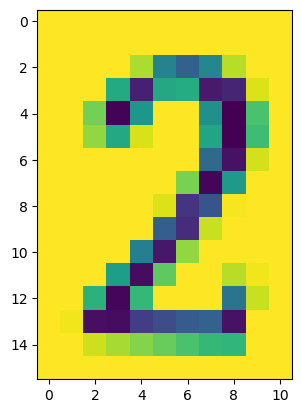

In [15]:
letter_image_file = 'extracted_letter_images/2/000001.png'

image = cv2.imread(letter_image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape) 
(h, w) = image.shape[:2] # note that cv.imread gets an array of h x w, h goes first
# add [:2] so that even if color image will work, not needed here though

plt.imshow(image)
plt.show()

Since `h > w`, we make sure `h` fits in our desired height value, e.g., 20:

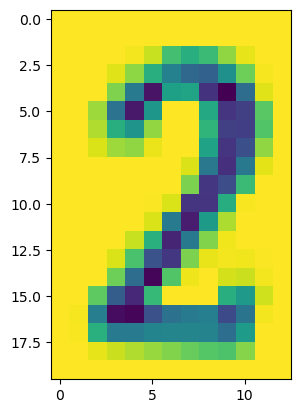

In [16]:
import imutils

image = imutils.resize(image, height=20)
# imutils.resize maintains the aspect ratio

plt.imshow(image)
plt.show()

Now we pad along width to make the image square, i.e., 20 x 20:

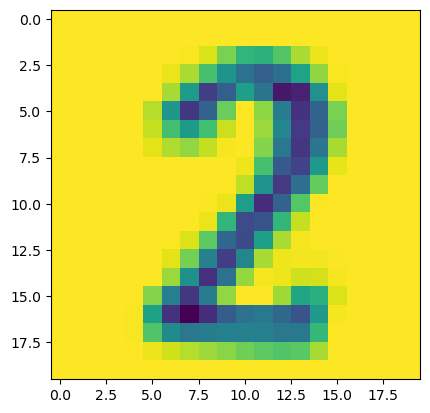

In [17]:
# determine the padding values for the width (= 20)
# to obtain the target dimensions
padW = int((20 - image.shape[1]) / 2.0) # may have rounding

# pad the image
image = cv2.copyMakeBorder(image, 0, 0, padW, padW,
        cv2.BORDER_REPLICATE)

# apply one more resizing to handle any rounding issues
image = cv2.resize(image, (20, 20))

plt.imshow(image)
plt.show()

Using what you learned, now write a function to resize images. Note that you also need to handle the possible case `h < w`:

In [18]:
def resize_to_fit(image, width, height):
    """
    A helper function to resize an image to fit within a given size
    - param image: image to resize
    - param width: desired width in pixels
    - param height: desired height in pixels
    - return: the resized image
    """

    #############################################################################
    # TODO: your code here ...                                                  #
    #############################################################################
    (he, wi) = image.shape[:2]

    if wi > he:
        image = imutils.resize(image, width=width)# if height is smaller than width, then resize width

    
    else:
        image = imutils.resize(image, height=height)# if width is smaller than height, then resize height

    
    h_pad = int((height - image.shape[0]) / 2.0)
    w_pad = int((width - image.shape[1]) / 2.0)
   

 
    image = cv2.copyMakeBorder(image, h_pad, h_pad, w_pad, w_pad,
        cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))

  
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

    # return the pre-processed image
    return image

Prepare the training and validating datasets:

In [74]:
from imutils import paths

# initialize the data and labels
data_labels = []

progress_folder = ''

# loop over the input images
# imutils.paths.list_images will list all images in the 32 subfolders
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]
    # extracted_letter_images/2/000001.png, after split
    # extracted_letter_images, 2, 000001.png
    # so 2 is the 2nd last, accessed using index -2
    
    if label != progress_folder:
        print('Processing Folder', label)
        progress_folder = label
    
    # Add the letter image and it's label to our training data
    data_labels.append((image,label))

Processing Folder 2
Processing Folder 3
Processing Folder 4
Processing Folder 5
Processing Folder 6
Processing Folder 7
Processing Folder 8
Processing Folder 9
Processing Folder A
Processing Folder B
Processing Folder C
Processing Folder D
Processing Folder E
Processing Folder F
Processing Folder G
Processing Folder H
Processing Folder J
Processing Folder K
Processing Folder L
Processing Folder M
Processing Folder N
Processing Folder P
Processing Folder Q
Processing Folder R
Processing Folder S
Processing Folder T
Processing Folder U
Processing Folder V
Processing Folder W
Processing Folder X
Processing Folder Y
Processing Folder Z


In [75]:
# shuffling training data, as we will use part of it for validation and we need labels to be balanced

import random

random.shuffle(data_labels)
data = [x[0] for x in data_labels]
labels = [x[1] for x in data_labels]

Convert lists into NumPy arrays as required by Keras for input + data normalization:

In [76]:
# scale the raw pixel intensities to the range [0, 1] (this is important!!!)
data = np.array(data, dtype="float") / 255.0

# you may also use std rather than 255, and center the data by mean as follows:
#data = (np.array(data, dtype="float") - data.mean()) / data.std()
# in this case you need to remember the mean and std for use during testing later

# scaling is not needed if you use BatchNormalization after Conv2D and before Activation

labels = np.array(labels)

In [42]:
data = np.array(data, dtype="float")

labels = np.array(labels)

Split into training and validation datasets:

In [77]:
from sklearn.preprocessing import LabelBinarizer

# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(labels)
print(lb.classes_)
labels = lb.transform(labels)
print()
print(labels)

['2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'J' 'K'
 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [78]:
import pickle

MODEL_LABELS_FILENAME = "model_labels.dat"

# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)

Now we are ready to train it using Keras. We’ll use a simple convolutional neural network architecture with two convolutional layers and two fully-connected layers:

In [79]:
import tensorflow as tensorflow
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

clear_session() # free existing Keras models

# Build the neural network!
model = Sequential()

# First convolutional layer with max pooling
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional layer with max pooling
model.add(Conv2D(50, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Hidden layer with 500 nodes
model.add(Flatten())
model.add(Dense(500, activation="relu"))

# Output layer with 32 nodes (one for each possible letter/number we predict)
model.add(Dense(32, activation="softmax"))

In [80]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 20)        520       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 50)        9050      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 50)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1250)              0         
                                                                 
 dense (Dense)               (None, 500)               6

In [ ]:
from IPython.display import Image

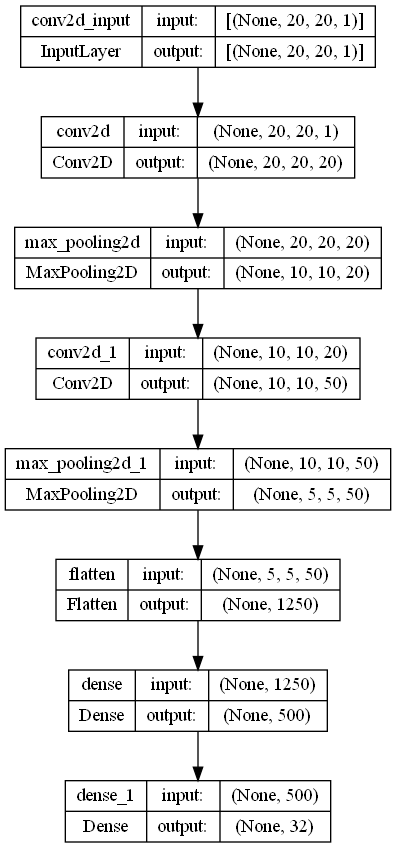

In [81]:
# from tensorflow.keras.utils import plot_model
from keras.utils import plot_model # if does not work properly, try the previous line instead

MODEL_PLOT_FILE = 'model_plot.png'
plot_model(model, to_file=MODEL_PLOT_FILE, show_shapes=True, show_layer_names=True)
display(Image(filename=MODEL_PLOT_FILE))

Questions: (1) Why `conv2d_1` has 9050 parameters? (2) Why `dense` has 625500 parameters?

Hint: self-study http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture5.pdf
    
(1)
A neural network's convolutional layer's parameter count depends on a variety of variables, including the size of the kernel, the number of input channels, the number of output channels, and whether the layer uses bias.We have two Conv2D layers.
number_of_parameters = outputChannelNumber * (inputChannelNumber * kernelHeight * kernelWidth + bias)
Layer 1: conv2d
number_of_parameters:20*(1*5*5+1)
Layer 2: conv2d_1
number_of_parameters:50*(20*3*3+1)=9050, where 20 is input channel number from the previous max pooling layer
(2)The number of parameters in dense layer depends upon the number of input channels and number of output channels and on whetther the layer uses bias.It can be calculated using
number_of_parameters = outputChannelNumber * (inputChannelNumber + bias)
Layer 1: dense
number_of_parameters:500*(1250+1)=625500 


Now, let us do the actual training:

In [83]:
# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [84]:
# Train the neural network, 20% of the data is used for validation
model.fit(data, labels, validation_split=0.20, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
969/969 [==============================] - 22s 21ms/step - loss: 0.2396 - accuracy: 0.9420 - val_loss: 0.0220 - val_accuracy: 0.9946
Epoch 2/10
969/969 [==============================] - 20s 20ms/step - loss: 0.0133 - accuracy: 0.9969 - val_loss: 0.0101 - val_accuracy: 0.9964
Epoch 3/10
969/969 [==============================] - 20s 21ms/step - loss: 0.0055 - accuracy: 0.9986 - val_loss: 0.0150 - val_accuracy: 0.9965
Epoch 4/10
969/969 [==============================] - 20s 20ms/step - loss: 0.0064 - accuracy: 0.9982 - val_loss: 0.0143 - val_accuracy: 0.9955
Epoch 5/10
969/969 [==============================] - 20s 20ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0089 - val_accuracy: 0.9978
Epoch 6/10
969/969 [==============================] - 19s 20ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0069 - val_accuracy: 0.9981
Epoch 7/10
969/969 [==============================] - 19s 20ms/step - loss: 0.0064 - accuracy: 0.9981 - val_loss: 0.0103 - val_accuracy:

Save the model for later use:

In [85]:
MODEL_FILENAME = "captcha_model.hdf5"

# Save the trained model to disk
model.save(MODEL_FILENAME)

In [59]:
#See what will happen if you do not scale your data by 255.0?
#HINT: simply train again with data/255.0 instead of 255, and see how the loss and acc look like;
#      you need to recreate your model by running the cell containing clear_session() before
data = np.array(data, dtype="float") / 255
labels = np.array(labels)
#[YOUR CODE HERE]

## Step 3: Use the model to solve CAPTCHAs!

The rest part can be run independently once models are saved.

Get an image from the online demo: https://contactform7.com/captcha/ and try our model on it:

In [86]:
# replace the url with the link of the image you see
# [Using the same image will cause points deducted !!!]
# !wget https://contactform7.com/wp-content/uploads/9kj/4034640145.png
# use the name of the file you downloaded
TEST_FILE_NAME = 'test.png'

# show the image
from IPython.display import Image

display(Image(filename=TEST_FILE_NAME))

Load saved model data:

In [87]:
from tensorflow.keras.models import load_model
import pickle

MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"

# Load up the model labels (so we can translate model predictions to actual letters)
with open(MODEL_LABELS_FILENAME, "rb") as f:
    lb = pickle.load(f)

# Load the trained neural network
model = load_model(MODEL_FILENAME)

Load packages and define functions for independent running of Part 3:

In [88]:
import numpy as np
import imutils
import cv2

# [!!! please also run the cell defining function "resize_to_fit" again, if you run Part 3 alone]

Get the letters from the downloaded images:

In [89]:
# Load the image and convert it to grayscale
image = cv2.imread(TEST_FILE_NAME)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Add some extra padding around the image
gray = cv2.copyMakeBorder(gray, 20, 20, 20, 20, cv2.BORDER_REPLICATE)

# threshold the image (convert it to pure black and white)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# find the contours (continuous blobs of pixels) the image
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
# !!! if the cell reports error, replace [0] above with [1]

letter_image_regions = []

# Now we can loop through each of the four contours and extract the letter
# inside of each one
for contour in contours:
    # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)
    letter_image_regions.append((x, y, w, h))

# If we found more or less than 4 letters in the captcha, our letter extraction
# didn't work correcly. Skip the image instead of saving bad training data!
if len(letter_image_regions) != 4:
    print('[WARNING]', TEST_FILE_NAME, 'has', len(letter_image_regions), 'contours, unable to process')
else:
    print('[SUCCESS]')

[SUCCESS]


If you see a warning, use another image instead and repeat the previous steps.

Otherwise, continue to create an output image:

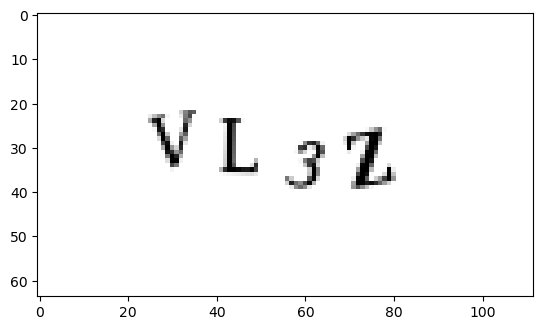

In [90]:
# Sort the detected letter images based on the x coordinate to make sure
# we are processing them from left-to-right so we match the right image
# with the right letter
letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

# Create an output image and a list to hold our predicted letters
output = cv2.merge([gray] * 3) # 2D gray image -> 3D color image

# show the 3D image
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
from matplotlib import pyplot as plt

#Show the image with matplotlib
plt.imshow(output)
plt.show()

1/1 [==============================] - 0s 40ms/step
CAPTCHA text is: VL3Z


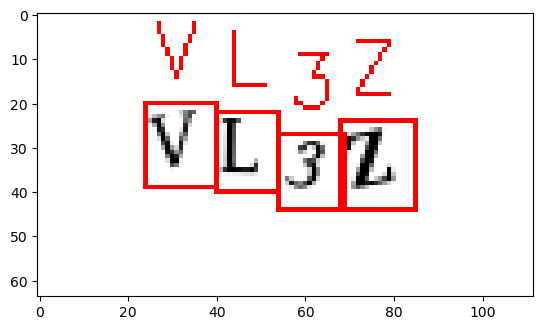

In [91]:
predictions = []

# Save out each letter as a single image
for letter_bounding_box in letter_image_regions:
    # Grab the coordinates of the letter in the image
    x, y, w, h = letter_bounding_box

    # Extract the letter from the original image with a 2-pixel margin around the edge
    letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

    # Re-size the letter image to 20x20 pixels to match training data
    letter_image = resize_to_fit(letter_image, 20, 20)
    
    # Turn the single image into a 4D list of images to make Keras happy
    # 4D: image_number (=1) x height x width x channel (=1)
    letter_image = np.expand_dims(letter_image, axis=2)
    letter_image = np.expand_dims(letter_image, axis=0)
    
    # Ask the neural network to make a prediction
    prediction = model.predict(letter_image) # output is one-hot encoded
        
    letter = lb.inverse_transform(prediction)[0]
    # use [0] since there is only one test data's label item in the list
    predictions.append(letter)
    
    # draw the prediction on the output image
    # (255, 0, 0) = red
    cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (255, 0, 0), 1)
    cv2.putText(output, letter, (x, y - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255, 0, 0), 1)

# see prediction result:

# Print the captcha's text
captcha_text = "".join(predictions)
print("CAPTCHA text is: {}".format(captcha_text))

# Show the annotated image
plt.imshow(output)
plt.show()

Questions: Is the prediction correct? How many letters are correctly predicted?
    
Yes.All 4 are correctly predicted